Predicting Trends of the S&P500

- The goal of this notebook is to identify when there is a market regime, 
- Github Link containing all datasets, notebooks, slides, and video: https://github.com/Niddish/MachineLearningForEngineersFinalProject 

In [238]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import yfinance as yf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



While this dataset contains the same data as the linked dataset, the original dataset was for stocks, not index funds like the S&P500. The .csv is in the GitHub link.

In [70]:
#generate dataset in correct format

def generate_spy_data(csv_filepath, start_date, end_date):
    spy_data = yf.download("SPY", start=start_date, end=end_date)
    spy_data.reset_index(inplace=True)
    spy_data = spy_data.rename(columns={
        "Date": "Date",
        "Open": "Open",
        "High": "High",
        "Low": "Low",
        "Close": "Close",
        "Adj Close": "Adj Close",
        "Volume": "Volume"
    })
    
    spy_data.to_csv(csv_filepath, index=False)
    print(f"S&P 500 data saved to {csv_filepath}")

generate_spy_data(
    csv_filepath="spy_data_1993_2024.csv",
    start_date="1993-01-01",
    end_date="2024-12-1"
)

[*********************100%***********************]  1 of 1 completed

S&P 500 data saved to spy_data_1993_2024.csv


In [104]:
#data exploration

#load data function
def load_data(csv_filepath):
    df = pd.read_csv(csv_filepath, index_col="Date", parse_dates=True)
    df["Returns"] = df["Adj Close"].pct_change()
    return df.dropna()

#load SPY data
csv_filepath = "spy_data_1993_2024.csv"
data = load_data(csv_filepath)

print(f"Number of samples (rows): {data.shape[0]}")
print(f"Number of raw features (columns): {data.shape[1]}")



Number of samples (rows): 8016
Number of raw features (columns): 7


Our data exploration shows 8016 rows and 7 columns, with the start corresponding to the first available record of the S&P500 stock. Each row is a different day, and each column correpsonds to a different finanical value such as Adj Close, Close, High, Low, Open, and Volume.

Below - plot of the SPY ETF over time, to visualize the trend. From this, we can see "dips" that, in hindsight, we would like to avoid (2008 and 2020 are some of the more obvious ones). This is where the hidden markov model shines, in finding these hidden states where there is heightened market volatility or unfavorable conditions. By identifying these hidden states, the Hidden Markov Model can help inform a strategy that avoids investing during these periods, potentially reducing drawdowns and improving risk-adjusted returns."

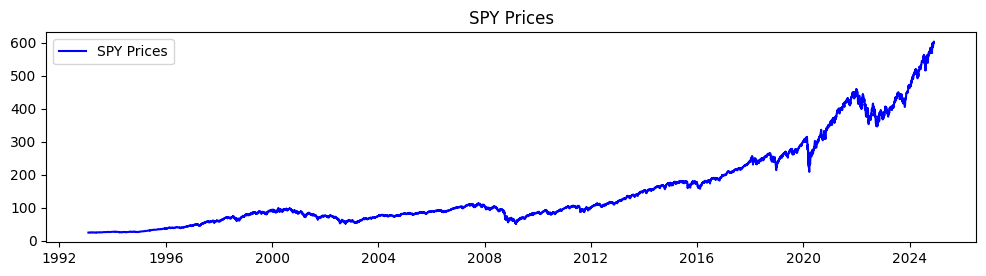

In [105]:
#plot SPY prices
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data.index, data["Adj Close"], label="SPY Prices", color="blue")
plt.title("SPY Prices")
plt.legend()

For preprocessing, the data is already clean (since we generated it), so there isn't really much to do other than check for NaN values

In [106]:
#preprocessing 

#ensure no missing values
missing_fraction = data.isnull().mean()  # Fraction of missing values per column
missing_fraction = missing_fraction[missing_fraction > 0]  # Filter columns with missing values
print(missing_fraction) #should be empty

print(data.head())


Series([], dtype: float64)
            Adj Close     Close      High       Low      Open  Volume  \
Date                                                                    
1993-02-01  24.783659  44.25000  44.25000  43.96875  43.96875  480500   
1993-02-02  24.836142  44.34375  44.37500  44.12500  44.21875  201300   
1993-02-03  25.098694  44.81250  44.84375  44.37500  44.40625  529400   
1993-02-04  25.203718  45.00000  45.09375  44.46875  44.96875  531500   
1993-02-05  25.186213  44.96875  45.06250  44.71875  44.96875  492100   

             Returns  
Date                  
1993-02-01  0.007113  
1993-02-02  0.002118  
1993-02-03  0.010571  
1993-02-04  0.004184  
1993-02-05 -0.000695  


For feature extraction, again, we are solely using stock data. Right now, we want to define the training and test data split for both the logisitic regression and HMM model. The reason that we include the split in feature extraction is for several reasons. One, since this is a time-series dataset, performing cross-valdiation is tricky/not feasible, since we need to maintain chronological order. Two, by splitting the data now, we prevent any potential data leakage from occuring later when calulating values like moving average.

In [ ]:
def feature_extraction_and_split(df):
    #ensure no missing values (again)
    df.dropna(inplace=True)

    #split train and test
    train_data = df.loc[:'2010-12-31']  #data up to 2010
    test_data = df.loc['2011-01-01':]  #data from 2011 onward

    return train_data, test_data

#apply this split
train_data, test_data = feature_extraction_and_split(data)

print("Training Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())



Training Data:
            Adj Close     Close      High       Low      Open  Volume  \
Date                                                                    
1993-02-01  24.783659  44.25000  44.25000  43.96875  43.96875  480500   
1993-02-02  24.836142  44.34375  44.37500  44.12500  44.21875  201300   
1993-02-03  25.098694  44.81250  44.84375  44.37500  44.40625  529400   
1993-02-04  25.203718  45.00000  45.09375  44.46875  44.96875  531500   
1993-02-05  25.186213  44.96875  45.06250  44.71875  44.96875  492100   

             Returns  
Date                  
1993-02-01  0.007113  
1993-02-02  0.002118  
1993-02-03  0.010571  
1993-02-04  0.004184  
1993-02-05 -0.000695  

Testing Data:
            Adj Close       Close        High         Low        Open  \
Date                                                                    
2011-01-03  98.665184  127.050003  127.599998  125.699997  126.709999   
2011-01-04  98.610825  126.980003  127.370003  126.190002  127.330002   
2011-

Our first method, the Hidden Markov Model (HMM) infers hidden states such as market regimes. It assumes that the system being modeled transitions between hidden states (e.g., bullish or bearish regimes) according to probabilistic rules, and each state produces observations with specific characteristics(like return distributions). In this implementation, the HMM is trained on historical stock returns, allowing it to learn the probabilities of transitioning between hidden states and the distribution of returns associated with each state. This is achieved by fitting the model on the "Returns" column of the training data, where the number of hidden states is specified as n_components=2 to represent two regimes, with those being high and low volatility.

After training, the HMM predicts hidden states for both the training and test datasets using the fitted model. These predicted states, stored as HMM_State, are then added as a new column to the respective datasets. This allows us to evaluate the model’s predictions on unseen data (test set) and use the predicted states as inputs for further applications, such as trading strategies.

Noteably, we don't perform cross-validation with this model.This is because cross-validation is challenging for HMMs, since these models are sequential in nature, relying on the order of observations. Randomly splitting or shuffling data, as is common in cross-validation, would break the temporal dependencies crucial to the model. Furthermore, HMMs are sensitive to initialization and may fail to converge during training, which complicates repeated validation across multiple splits (this happened when I tried to implement it). As a result, we rely on separate training and testing periods to evaluate performance realistically.

In [256]:
#ML technique 1 - Hidden Markov Model

#train the model
def train_hmm(train_data, n_components=2):
    returns = train_data["Returns"].values.reshape(-1, 1)
    hmm_model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
    hmm_model.fit(returns)
    return hmm_model

hmm_model = train_hmm(train_data)

#predict HMM states on train and test data
hmm_train_states = hmm_model.predict(train_data["Returns"].values.reshape(-1, 1))
hmm_test_states = hmm_model.predict(test_data["Returns"].values.reshape(-1, 1))

#add these values as targets to dataset - we do this so they
#can be used later for backtesting or model comparison 
train_data["HMM_State"] = hmm_train_states
test_data["HMM_State"] = hmm_test_states


print("Hidden Markov Model Trained.")

print("State Transition Matrix:\n")
print(hmm_model.transmat_)




Hidden Markov Model Trained.
State Transition Matrix:

[[0.98865038 0.01134962]
 [0.02698003 0.97301997]]


The "State Transition Matrix" is printed to reveal the probabilities of moving from one hidden state to another, providing insights into the dynamics of market regimes. From these values, we can say that the HMM thinks that: When the market is in a period of high volatility, it is over 97% likely to stay in that period of high volatility. Likewise, if it is in a state of low volatility, it is again very likely to stay in that low volatility area.

The second method used in this notebook is the Random Forest classifier, and we use it to predict market regimes based on stock returns as well as the hidden states inferred by the HMM as the target. While this may seem odd, treating the HMM outputs as the ground truth allows for Random Forest to emulate the HMMs regime detection, and furthermore, allows for comparison between the two(it was difficult to find metrics and a model to compare the HMM to). We chose Random Forest because of its robustness and resistance to overfitting with minimal parameter tuning. The features for the Random Forest (X_train and X_test) are the "Returns" columns from the training and testing datasets. These stock returns serve as the primary input for the HMM, and thus they are also used to train the Random Forest. The target variable (y_train and y_test) consists of the hidden states predicted by the HMM. We use 5-fold cross validation, which we can do in this classifier because Random Forests do not rely on the sequential order of data, so the data can be shuffled and split randomly without breaking dependencies. After evaluating the model using cross-validation, the Random Forest is trained on the entire training dataset. Predictions are made on the test set, and the predicted states are stored in the test dataset under the column RF_State. The model's performance is assessed using metrics like cross-validation accuracy and test set accuracy. The reasons described above make RF a fair and robust comparison with the HMM.

In [239]:
#ML technique 2 - Random Forest classifier

X_train = train_data[["Returns"]]
y_train = hmm_model.predict(train_data["Returns"].values.reshape(-1, 1))  #use HMM states as targets

X_test = test_data[["Returns"]]
y_test = hmm_model.predict(test_data["Returns"].values.reshape(-1, 1))

#initalize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

#perform cross validation across 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42) 
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')

#train, predict, display results
rf_model.fit(X_train, y_train)
test_data["RF_State"] = rf_model.predict(X_test)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Test Set Accuracy:", accuracy_score(y_test, test_data["RF_State"]))

print("Random Forest Model Trained and Predictions Added.")





Cross-Validation Accuracy Scores: [0.66814159 0.69764012 0.68584071 0.67182891 0.68339483]
Mean CV Accuracy: 0.6813692322763936
Test Set Accuracy: 0.6496763754045307
Random Forest Model Trained and Predictions Added.


For our evaluation metrics, the performance of the Hidden Markov Model (HMM) and Random Forest (RF) models were evaluated and compared based on their ability to predict market regimes and their effectiveness in guiding a simple backtest trading strategy. The Random Forest model was trained on historical returns data using the HMM states as the target variable, enabling it to learn patterns similar to those identified by the HMM. The accuracy of the Random Forest in predicting HMM states on the test dataset was 64.97%, as indicated by the confusion matrix and classification report. While the RF model demonstrated reasonable performance, it struggled slightly with classifying one of the states, leading to a lower precision and recall for the minority class.

A simple backtesting strategy was implemented to simulate the trading performance of both models. The strategy assumes a trade in a low-volatility regime (state 0) and no trading activity in other regimes. For both HMM and RF, cumulative returns were calculated and analyzed. Two key metrics, Sharpe Ratio (a measure of risk-adjusted returns) and Maximum Drawdown (the largest observed loss from a peak to a trough), were used to evaluate the performance of the trading strategies.

RF had a higher Sharpe ratio, meaning that the risk-adjusted returns were slightly better. However, this came at the cost of a lower max drawdown, signifying potentially greater loss during market instability. Overall, both methods performed well, with the HMM being more useful for our practical application since it mimimizes risk better.



In [257]:
#evaluation metrics

#RF state predictions
rf_hmm_states = rf_model.predict(X_test)

#evaluate RF metrics
print("Random Forest vs. HMM States Performance:")
print("Accuracy:", accuracy_score(y_test, rf_hmm_states))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_hmm_states))
print("Classification Report:\n", classification_report(y_test, rf_hmm_states))

#simple backtest
def backtest_strategy(df, state_column):
    """
    Backtest strategy using a state column (HMM_State or RF_State).
    """
    df["Signal"] = (df[state_column] == 0).astype(int)  #trade in regime 0 (low volatility)
    invested = False
    cumulative_returns = [1.0]

    for i in range(len(df)):
        if i < 1:
            cumulative_returns.append(cumulative_returns[-1])
            continue

        #simple trading logic
        if df["Signal"].iloc[i] == 1:
            invested = True
        else:
            invested = False

        #simulated returns
        daily_return = df["Returns"].iloc[i] if invested else 0.0
        cumulative_returns.append(cumulative_returns[-1] * (1 + daily_return))

    df["Cumulative_Returns"] = pd.Series(cumulative_returns[1:], index=df.index)
    return df["Cumulative_Returns"]

#apply backtesting to both models
test_data["HMM_Cumulative"] = backtest_strategy(test_data.copy(), "HMM_State")
test_data["RF_Cumulative"] = backtest_strategy(test_data.copy(), "RF_State")


#evaluation metrics
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

#HMM metrics
hmm_sharpe = calculate_sharpe_ratio(test_data["HMM_Cumulative"].pct_change().dropna())
hmm_drawdown = calculate_max_drawdown(test_data["HMM_Cumulative"])

#RF metrics
rf_sharpe = calculate_sharpe_ratio(test_data["RF_Cumulative"].pct_change().dropna())
rf_drawdown = calculate_max_drawdown(test_data["RF_Cumulative"])

print(f"HMM Sharpe Ratio: {hmm_sharpe:.4f}, Max Drawdown: {hmm_drawdown:.4%}")
print(f"RF Sharpe Ratio: {rf_sharpe:.4f}, Max Drawdown: {rf_drawdown:.4%}")



Random Forest vs. HMM States Performance:
Accuracy: 0.6496763754045307
Confusion Matrix:
 [[578 166]
 [267 225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73       744
           1       0.58      0.46      0.51       492

    accuracy                           0.65      1236
   macro avg       0.63      0.62      0.62      1236
weighted avg       0.64      0.65      0.64      1236

HMM Sharpe Ratio: 0.1511, Max Drawdown: -9.9743%
RF Sharpe Ratio: 0.1683, Max Drawdown: -12.1837%


Our practical application involves training a HMM on historical stock data to identify market regimes and uses the predicted states to guide a trading strategy. The HMM is trained using the adjusted closing price returns from 1993 to 2019, while data from 2020 to the end of 2024 is reserved for backtesting. The trading strategy relies on a Moving Average Crossover rule combined with HMM-predicted states for risk management. Specifically, trades are executed only during low-volatility regimes (state 0) identified by the HMM. The strategy attempts to leverage periods of stable market behavior for better returns while avoiding volatile regimes.

To go into more detail about the strategy, trades are executed only during low-volatility regimes (state 0), as identified by the HMM, and follow the moving average signals to capture upward trends while avoiding high-risk periods. This approach ensures risk-aware trading by minimizing exposure during volatile markets and focusing on stable conditions for improved performance.

As we can see from the chart, we avoid losing too much money during the early months of 2020, and actually goes on to outperform the SPY ETF. However, this is obviously theoretical, and doesn't account for things like broker fees. Not only that, the previous issues with the HMM not converging could also prove problematic. That being said, this method is certainly one to look into more, as just from this initial analysis, it seems promising.



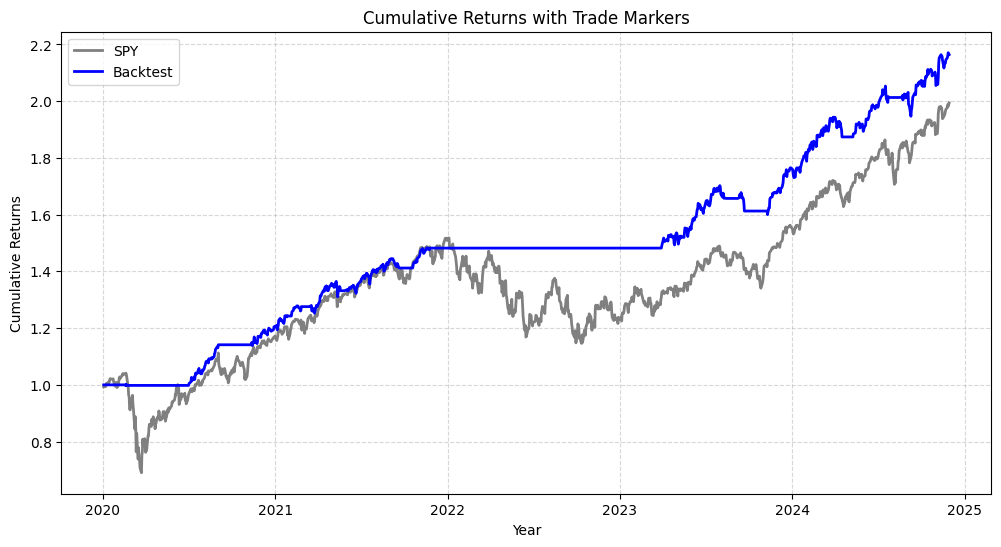

In [ ]:
#practical application

def backtest_strategy(df, hmm_model):
    short_window = 10
    long_window = 30
    
    df["Short_MA"] = df["Adj Close"].rolling(short_window).mean()
    df["Long_MA"] = df["Adj Close"].rolling(long_window).mean()
    df["Signal"] = 0  # 1 = buy, 0 = sell
    
    invested = False
    cumulative_returns = [1.0]
    hidden_states = hmm_model.predict(df["Returns"].values.reshape(-1, 1))
    
    #start backtesting when the first long window is available
    start_index = long_window
    
    for i in range(len(df)):
        if i < start_index:
            cumulative_returns.append(cumulative_returns[-1])  
            continue
        
        regime = hidden_states[i]
        
        #check moving average crossover
        if df["Short_MA"].iloc[i] > df["Long_MA"].iloc[i] and not invested and regime == 0:
            invested = True
        elif df["Short_MA"].iloc[i] < df["Long_MA"].iloc[i] and invested:
            invested = False
        
        #apply risk managment filter
        daily_return = df["Returns"].iloc[i] if invested and regime == 0 else 0.0
        cumulative_returns.append(cumulative_returns[-1] * (1 + daily_return))
    
    #align with df index
    df["Cumulative_Returns"] = cumulative_returns[:len(df)]
    return df, hidden_states

def plot_results_single_color(df, spy_cumulative, marker_color="green"):
    """
    Plot cumulative returns for the SPY benchmark and strategy,
    highlighting all trades with a single color.
    """
    plt.figure(figsize=(12, 6))
    
    #plot the SPY returns
    plt.plot(df.index, spy_cumulative, label="SPY", color="gray", linewidth=2)
    
    #plot our strategy retursn
    plt.plot(df.index, df["Cumulative_Returns"], label="Backtest", color="blue", linewidth=2)

    plt.title("Cumulative Returns with Trade Markers")
    plt.xlabel("Year")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


# Path to data
csv_filepath = "spy_data_1993_2024.csv"
    
#load more recent data
train_data = load_data(csv_filepath, "1993-01-29", "2019-12-31")
test_data = load_data(csv_filepath, "2020-01-01", "2024-12-1")

#train HMM on this data
hmm_model = train_hmm(train_data)

#backtest
backtested_data, hidden_states = backtest_strategy(test_data, hmm_model)

#calculate the returns for the SPY
spy_cumulative = (1 + test_data["Returns"]).cumprod()

#plot
plot_results_single_color(backtested_data, spy_cumulative)

Bibliography

- https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs?resource=download

- https://www.quantstart.com/articles/hidden-markov-models-an-introduction/

- https://www.geeksforgeeks.org/hidden-markov-model-in-machine-learning/

- https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/
